# Calculate Detector Counts: Simple
Calculate AIA response at each time for the whole active region using only the temperature response functions.

In [1]:
import os
import sys

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.colors
import dask
import distributed
import sunpy.map

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.visualize import plot_aia_channels

sys.path.append('/storage-home/w/wtb2/projects/synthesized_timelag_maps/scripts/')
from timelags import AIATimeLags

%matplotlib inline

In [2]:
client = distributed.Client(processes=False)
client

Client Scheduler: inproc://128.42.128.76/138691/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 64 Memory: 270.38 GB


In [ ]:
field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/field_checkpoint/')

In [3]:
aia = InstrumentSDOAIA([0,10000] * u.s, use_temperature_response_functions=True,)

In [ ]:
observer = synthesizAR.Observer(field,[aia],parallel=True)

In [ ]:
observer.build_detector_files('/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/simple/',
                              ds=1 * u.arcsec,)

In [ ]:
tasks = observer.flatten_detector_counts()

In [ ]:
tasks['SDO_AIA_parameters'].compute()

In [ ]:
tasks['SDO_AIA_counts'].compute()

In [ ]:
tasks = observer.bin_detector_counts('/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/simple/')

In [ ]:
jobs = client.compute(tasks['SDO_AIA'])

In [ ]:
jobs = None

## Visualization and Quick Analysis

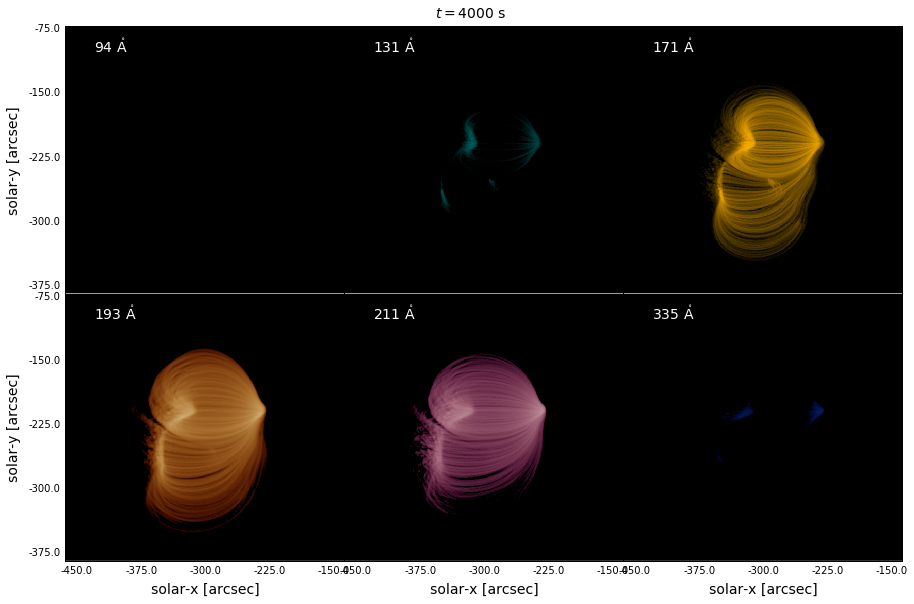

In [4]:
aia.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/simple/SDO_AIA_counts.h5'
plot_aia_channels(aia, 
                  4000 * u.s, 
                  '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/simple',
                  norm=matplotlib.colors.SymLogNorm(1e-10,vmin=2,vmax=1e4),
                  figsize=(15,9)
                 )

In [5]:
tl = AIATimeLags(aia, '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/simple/', 
                 #crop=crop
                )

FloatProgress(value=0.0)

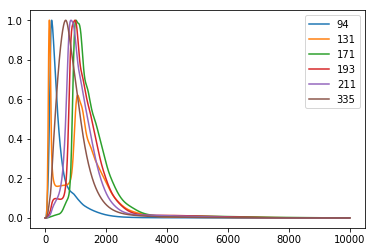

In [6]:
llc,urc = (-375 * u.arcsec, -275 * u.arcsec),(-300 * u.arcsec,-250 * u.arcsec)
for i,channel in enumerate(aia.channels):
    ts = tl.make_timeseries(tl.cubes, channel['name'], llc, urc)
    plt.plot(aia.observing_time, ts/ts.max(), color=f'C{i}',label=channel['name'])
plt.legend()
#plt.xlim(0,4000)

(-10000.0, 10000.0)

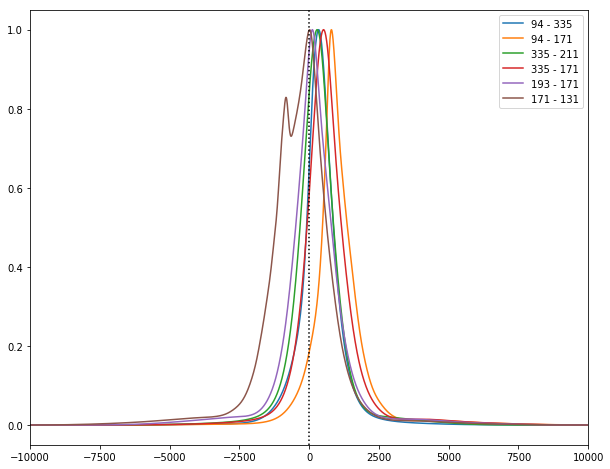

In [7]:
channel_pairs = [(94,335),(94,171),(335,211),(335,171),(193,171),(171,131)]
plt.figure(figsize=(10,8))
for i,p in enumerate(channel_pairs):
    cc = tl.correlation_1d(f'{p[0]}', f'{p[1]}', llc, urc)
    plt.plot(tl.timelags,cc/cc.max(),color=f'C{i}',ls='-',label=f'{p[0]} - {p[1]}')
plt.axvline(x=0,ls=':',color='k')
plt.legend()
plt.xlim(-1e4,1e4)

In [8]:
correlation_map, timelag_map = tl.make_timelag_map('94','335',)

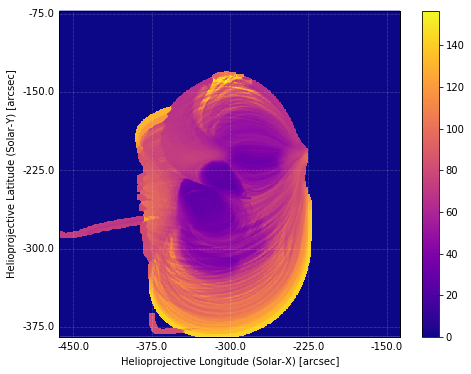

In [9]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection=correlation_map)
im = correlation_map.plot(axes=ax,title=False,)
fig.colorbar(im)

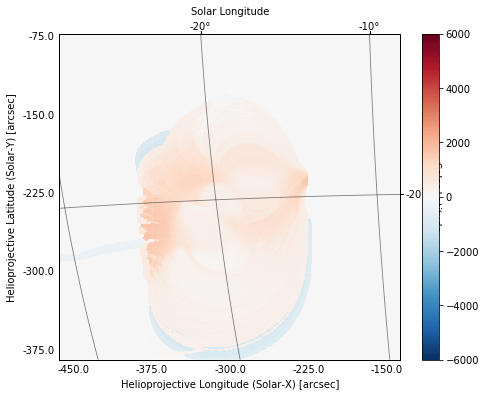

In [10]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection=timelag_map)
im = timelag_map.plot(axes=ax,title=False,cmap='RdBu_r',vmin=-6e3,vmax=6e3)
timelag_map.draw_grid(color='k',grid_spacing=10 * u.deg)
fig.colorbar(im)

(-3000.0, 3000.0)

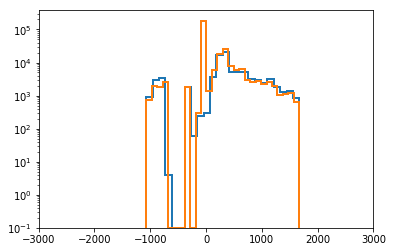

In [11]:
timelags_flat = timelag_map.data.flatten()
correlations_flat = correlation_map.data.flatten()
timelags_flat_filtered = timelags_flat[np.where(correlations_flat > 0.3 * correlations_flat.max())]
plt.hist(timelags_flat_filtered,bins='doane',histtype='step',lw=2,log=True,color='C0');
plt.hist(timelags_flat,bins='doane',histtype='step',lw=2,log=True,color='C1')
plt.xlim(-3e3,3e3)